In [ ]:
# @title Copyright & License (click to expand)
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Model Monitoring with Explainable AI Feature Attributions

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/model_monitoring/model_monitoring.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/model_monitoring/model_monitoring.ipynb">
        <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
    <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/model_monitoring/model_monitoring.ipynb">
       <img src="https://www.gstatic.com/cloud/images/navigation/vertex-ai.svg" alt="Vertex AI logo">Open in Vertex AI Workbench
    </a>
</table>

## Overview

### What is Vertex AI Model Monitoring?

Modern applications rely on a well established set of capabilities to monitor the health of their services. Examples include:

* software versioning
* rigorous deployment processes
* event logging
* alerting/notication of situations requiring intervention
* on-demand and automated diagnostic tracing
* automated performance and functional testing

You should be able to manage your ML services with the same degree of power and flexibility with which you can manage your applications. That's what MLOps is all about - managing ML services with the best practices Google and the broader computing industry have learned from generations of experience deploying well engineered, reliable, and scalable services.

Model monitoring is only one piece of the ML Ops puzzle - it helps answer the following questions:

* How well do recent service requests match the training data used to build your model? This is called **training-serving skew**.
* How significantly are service requests evolving over time? This is called **drift detection**.

[Vertex Explainable AI](https://cloud.google.com/vertex-ai/docs/explainable-ai/overview) adds another facet to model monitoring, which we call feature attribution monitoring. Explainable AI enables you to understand the relative contribution of each feature to a resulting prediction. In essence, it assesses the magnitude of each feature's influence.

If production traffic differs from  training data, or varies substantially over time, **either in terms of model predictions or feature attributions**, that's likely to impact the quality of the answers your model produces. When that happens, you'd like to be alerted automatically and responsively, so that **you can anticipate problems before they affect your customer experiences or your revenue streams**.

Learn more about [Vertex AI Model Monitoring](https://cloud.google.com/vertex-ai/docs/model-monitoring).

### Objective

In this notebook, you learn to use the `Vertex AI Model Monitoring` service to detect drift and anomalies in prediction requests from a deployed `Vertex AI Model` resource.

This tutorial uses the following Google Cloud ML services:

- `Vertex AI Model Monitoring`
- `Vertex AI Prediction`
- `Vertex AI Model` resource
- `Vertex AI Endpoint` resource

The steps performed include:

- Upload a pre-trained model as a `Vertex AI Model` resource.
- Create an `Vertex AI Endpoint` resource.
- Deploy the `Model` resource to the `Endpoint` resource.
- Configure the `Endpoint` resource for model monitoring.
- Initialize the baseline distribution for model monitoring.
- Generate synthetic prediction requests.
- Understand how to interpret the statistics, visualizations, other data reported by the model monitoring feature.

### Model

This tutorial uses a pre-trained model, where the model artifacts are stored in a public Cloud Storage bucket. The model predicts for an online gaming site, the probability that a player may churn, i.e. stop being an active player.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* BigQuery
* Cloud Storage

Learn about [Vertext AI pricing](https://cloud.google.com/vertex-ai/pricing),
[Cloud Storage pricing](https://cloud.google.com/storage/pricing),
and [BigQuery pricing](https://cloud.google.com/bigquery/pricing)
and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Installation

Install the packages required for executing this notebook.

In [1]:
# Don't bother installing tensorflow or explainable_ai_sdk on Colab

# Install required packages.
! pip3 install --upgrade --quiet \
    google-cloud-aiplatform \
    google-cloud-bigquery \
    explainable_ai_sdk
#! pip3 install --upgrade --quiet tensorflow==2.11
! pip3 install --force-reinstall protobuf==4.23.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.3/122.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.23.3 which is incompatible.


### Colab only: Uncomment the following cell to restart the kernel

In [2]:
# Automatically restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## Before you begin

### Set your project ID

**If you don't know your project ID**, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [1]:
PROJECT_ID = "crypto-isotope-366706"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

Updated property [core/project].


#### Region

You can also change the `REGION` variable used by Vertex AI. Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [2]:
REGION = "us-central1"

#### User Email

Set your user email address to receive monitoring alerts.

In [3]:
import os

USER_EMAIL = "wngusdlehd@snu.ac.kr"  # @param {type:"string"}

if os.getenv("IS_TESTING"):
    USER_EMAIL = "noreply@google.com"

### Authenticate your Google Cloud account

Depending on your Jupyter environment, you may have to manually authenticate. Follow the relevant instructions below.

**1. Vertex AI Workbench**
* Do nothing as you are already authenticated.

**2. Local JupyterLab instance, uncomment and run:**

In [ ]:
# ! gcloud auth login

**3. Colab, uncomment and run:**

In [4]:
from google.colab import auth
auth.authenticate_user()

**4. Service account or other**
* See how to grant Cloud Storage permissions to your service account at https://cloud.google.com/storage/docs/gsutil/commands/iam#ch-examples.

### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [5]:
BUCKET_URI = f"gs://your-bucket-name-{PROJECT_ID}-unique"  # @param {type:"string"}

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI

### Notes about service account and permission

**By default no configuration is required**, if you run into any permission related issue, please make sure the service accounts above have the required roles:

|Service account email|Description|Roles|
|---|---|---|
|PROJECT_NUMBER-compute@developer.gserviceaccount.com|Compute Engine default service account|Dataflow Admin, Dataflow Worker, Storage Admin, BigQuery Admin, Vertex AI User|
|service-PROJECT_NUMBER@gcp-sa-aiplatform.iam.gserviceaccount.com|AI Platform Service Agent|Vertex AI Service Agent|


1. Goto https://console.cloud.google.com/iam-admin/iam.
2. Check the "Include Google-provided role grants" checkbox.
3. Find the above emails.
4. Grant the corresponding roles.

### Using data source from a different project
- For the BQ data source, grant both service accounts the "BigQuery Data Viewer" role.
- For the CSV data source, grant both service accounts the "Storage Object Viewer" role.

### Import libraries and define constants

In [6]:
# Import required packages.
import os
import pprint as pp

import google.cloud.aiplatform as aiplatform
import matplotlib.pyplot as plt
from google.cloud import bigquery
from google.cloud.aiplatform import model_monitoring
from google.cloud.aiplatform.explain.metadata.tf.v2 import \
    saved_model_metadata_builder

In [7]:
if os.getenv("IS_TESTING"):
    ! gcloud --quiet components install beta
    ! gcloud --quiet components update

! gcloud config set ai/region $REGION
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID

Updated property [ai/region].


### Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [8]:
aiplatform.init(project=PROJECT_ID, location=REGION)

### Create BigQuery client

In this tutorial, you use data from the same public BigQuery table that was used to train the pre-trained model. You create a client interface, which you subsequently use to access the data.

In [9]:
bqclient = bigquery.Client(project=PROJECT_ID)

### The example model

The model you use in this notebook is based on [this blog post](https://cloud.google.com/blog/topics/developers-practitioners/churn-prediction-game-developers-using-google-analytics-4-ga4-and-bigquery-ml). The idea behind this model is that your company has extensive log data describing how your game users have interacted with the site. The raw data contains the following categories of information:

- identity - unique player identitity numbers
- demographic features - information about the player, such as the geographic region in which a player is located
- behavioral features - counts of the number of times a  player has triggered certain game events, such as reaching a new level
- churn propensity - this is the label or target feature, it provides an estimated probability that this player will churn, i.e. stop being an active player.

The blog article referenced above explains how to use BigQuery to store the raw data, pre-process the data for machine learning, and train the corresponding model. Because this notebook focuses on model monitoring, rather than training models, you're going to reuse a pre-trained version of this model, which has been exported to Cloud Storage. In the next section, you will setup your environment and import this model into your own project.

### Define some helper data structures

Run the following cell to define some data structures used throughout this notebook.

In [11]:
# @title Utility data structures

# Sampling distributions for categorical features...
DAYOFWEEK = {1: 1040, 2: 1223, 3: 1352, 4: 1217, 5: 1078, 6: 1011, 7: 1110}

LANGUAGE = {
    "en-us": 4807,
    "en-gb": 678,
    "ja-jp": 419,
    "en-au": 310,
    "en-ca": 299,
    "de-de": 147,
    "en-in": 130,
    "en": 127,
    "fr-fr": 94,
    "pt-br": 81,
    "es-us": 65,
    "zh-tw": 64,
    "zh-hans-cn": 55,
    "es-mx": 53,
    "nl-nl": 37,
    "fr-ca": 34,
    "en-za": 29,
    "vi-vn": 29,
    "en-nz": 29,
    "es-es": 25,
}

OS = {"IOS": 3980, "ANDROID": 3798, "null": 253}

MONTH = {6: 3125, 7: 1838, 8: 1276, 9: 1718, 10: 74}

COUNTRY = {
    "United States": 4395,
    "India": 486,
    "Japan": 450,
    "Canada": 354,
    "Australia": 327,
    "United Kingdom": 303,
    "Germany": 144,
    "Mexico": 102,
    "France": 97,
    "Brazil": 93,
    "Taiwan": 72,
    "China": 65,
    "Saudi Arabia": 49,
    "Pakistan": 48,
    "Egypt": 46,
    "Netherlands": 45,
    "Vietnam": 42,
    "Philippines": 39,
    "South Africa": 38,
}

# Means and standard deviations for numerical features...
MEAN_SD = {
    "julianday": (204.6, 34.7),
    "cnt_user_engagement": (30.8, 53.2),
    "cnt_level_start_quickplay": (7.8, 28.9),
    "cnt_level_end_quickplay": (5.0, 16.4),
    "cnt_level_complete_quickplay": (2.1, 9.9),
    "cnt_level_reset_quickplay": (2.0, 19.6),
    "cnt_post_score": (4.9, 13.8),
    "cnt_spend_virtual_currency": (0.4, 1.8),
    "cnt_ad_reward": (0.1, 0.6),
    "cnt_challenge_a_friend": (0.0, 0.3),
    "cnt_completed_5_levels": (0.1, 0.4),
    "cnt_use_extra_steps": (0.4, 1.7),
}

DEFAULT_INPUT = {
    "cnt_ad_reward": 0,
    "cnt_challenge_a_friend": 0,
    "cnt_completed_5_levels": 1,
    "cnt_level_complete_quickplay": 3,
    "cnt_level_end_quickplay": 5,
    "cnt_level_reset_quickplay": 2,
    "cnt_level_start_quickplay": 6,
    "cnt_post_score": 34,
    "cnt_spend_virtual_currency": 0,
    "cnt_use_extra_steps": 0,
    "cnt_user_engagement": 120,
    "country": "Denmark",
    "dayofweek": 3,
    "julianday": 254,
    "language": "da-dk",
    "month": 9,
    "operating_system": "IOS",
    "user_pseudo_id": "104B0770BAE16E8B53DF330C95881893",
}

### Generate model metadata for Vertex Explainable AI

Run the following cell to extract metadata from the exported model, which is needed for generating the explanations for a prediction request.

In [12]:
MODEL_PATH = "gs://mco-mm/churn"

params = {"sampled_shapley_attribution": {"path_count": 10}}
EXPLAIN_PARAMS = aiplatform.explain.ExplanationParameters(params)

builder = saved_model_metadata_builder.SavedModelMetadataBuilder(
    model_path=MODEL_PATH, outputs_to_explain=["churned_probs"]
)
EXPLAIN_META = builder.get_metadata_protobuf()

## Upload your model

The churn propensity model you use in this notebook has been trained in BigQuery ML and exported to a Cloud Storage bucket. This illustrates how you can easily export a trained model and move a model from one cloud service to another.

Run the next cell to import this model into your project. **If you've already imported your model, you can skip this step.**

In [13]:
MODEL_NAME = "churn"
IMAGE = "us-docker.pkg.dev/cloud-aiplatform/prediction/tf2-cpu.2-5:latest"

model = aiplatform.Model.upload(
    display_name=MODEL_NAME,
    artifact_uri=MODEL_PATH,
    serving_container_image_uri=IMAGE,
    explanation_parameters=EXPLAIN_PARAMS,
    explanation_metadata=EXPLAIN_META,
    sync=True,
)

MODEL_ID = model.resource_name.split("/")[-1]

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/848384636885/locations/us-central1/models/3052526853194514432/operations/1319876882086232064
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/848384636885/locations/us-central1/models/3052526853194514432@1
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/848384636885/locations/us-central1/models/3052526853194514432@1')


Once the above cell completes, you should see a new model on the Vertex AI Model Registry page on the Cloud Console.

## Deploy your Model resource to an Endpoint resource

Now that you've imported your model into your project, you need to create an endpoint to serve your model. An endpoint can be thought of as a channel through which your model provides prediction services. Once established, you can make online prediction requests on your model via the public internet.  Your endpoint is also serverless, in the sense that Google Cloud ensures high availability by reducing single points of failure, and scalability by dynamically allocating resources to meet the demand for your service. In this way, you are able to focus on your model quality, and freed from adminstrative and infrastructure concerns.

Run the next cell to deploy your model to an endpoint. **This will take about ten minutes to complete.**

In [14]:
endpoint = model.deploy(machine_type="n1-standard-4")
print(f"endpoint display name: {endpoint.display_name}")
print(f"endpoint resource name: {endpoint.resource_name}")
ENDPOINT = endpoint.resource_name
ENDPOINT_ID = ENDPOINT.split("/")[-1]

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/848384636885/locations/us-central1/endpoints/6755406038125510656/operations/6158150256765698048
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/848384636885/locations/us-central1/endpoints/6755406038125510656
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/848384636885/locations/us-central1/endpoints/6755406038125510656')
INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/848384636885/locations/us-central1/endpoints/6755406038125510656
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/848384636885/locations/us-central1/endpoints/6755406038125510656/operations/3245165722787119104
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/84838463688

endpoint display name: churn_endpoint
endpoint resource name: projects/848384636885/locations/us-central1/endpoints/6755406038125510656


Once the above cell completes, you should see a new endoint
on the Vertex AI Endpoints page on the Cloud Console.

## Run a prediction test

Now that you have imported a model and deployed that model to an endpoint, you are ready to verify that it's working. Run the next cell to send a test prediction request. If everything works as expected, you should receive a response encoded in a text representation called JSON, along with a pie chart summarizing the results.

**Try this now by running the next cell.**

1 0.870577692165845
0 0.129422307834155
Prediction(predictions=[{'churned_probs': [0.870577692165845, 0.129422307834155], 'predicted_churned': ['1'], 'churned_values': ['1', '0']}], deployed_model_id='8882697155081404416', metadata=None, model_version_id='1', model_resource_name='projects/848384636885/locations/us-central1/models/3052526853194514432', explanations=None)


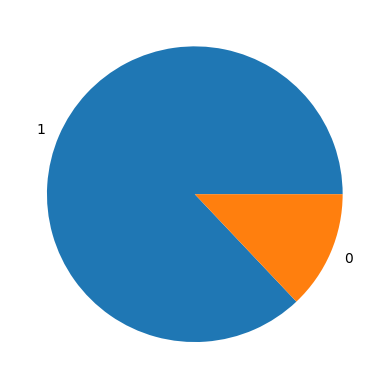

In [15]:
try:
    resp = endpoint.predict([DEFAULT_INPUT])
    for i in resp.predictions:
        vals = i["churned_values"]
        probs = i["churned_probs"]
    for i in range(len(vals)):
        print(vals[i], probs[i])
    plt.pie(probs, labels=vals)
    pp.pprint(resp)
except Exception as ex:
    print("prediction request failed", ex)

### Test results

Taking a look at the results, you see the following elements:

- **churned_values** - a set of possible values (0 and 1) for the target field
- **churned_probs** - a corresponding set of probabilities for each possible target field value (5x10^-40 and 1.0, respectively)
- **predicted_churn** - based on the probabilities, the predicted value of the target field (1)

This response encodes the model's prediction in a format that is readily digestible by software, which makes this service ideal for automated use by an application.

## Run an explanation test

You can run a test of Explainable AI on this endpoint. Run the next cell to send a test explanation request. The response you receive encodes the feature importance of this prediction in a text representation called JSON, along with a bar chart summarizing the results.

**Try this now by running the next cell.**

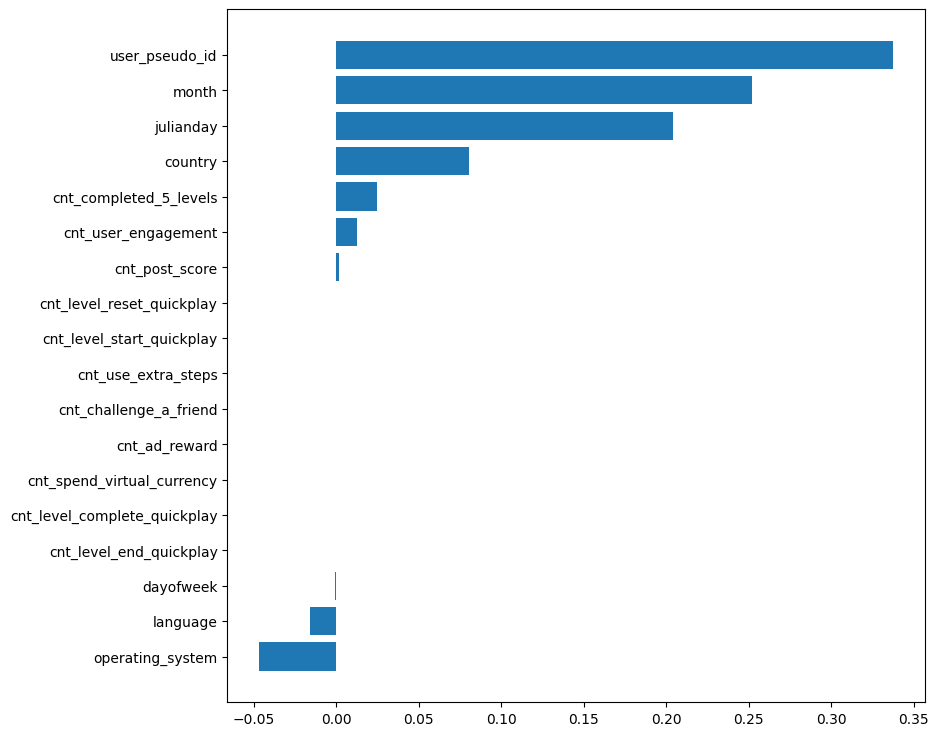

In [16]:
try:
    features = []
    scores = []
    resp = endpoint.explain([DEFAULT_INPUT])
    for i in resp.explanations:
        for j in i.attributions:
            for k in j.feature_attributions:
                features.append(k)
                scores.append(j.feature_attributions[k])
    features = [x for _, x in sorted(zip(scores, features))]
    scores = sorted(scores)
    fig, ax = plt.subplots()
    fig.set_size_inches(9, 9)
    ax.barh(features, scores)
    fig.show()
except Exception as ex:
    print("explanation request failed", ex)

## Start your monitoring job

Now that you've created an endpoint to serve prediction requests on your model, you're ready to start a monitoring job to keep an eye on model quality and to alert you if and when input begins to deviate in way that may impact your model's prediction quality.

In this section, you configure and create a model monitoring job based on the churn propensity model you imported from BigQuery ML.

### Configure the following fields:

1. Log sample rate - Your prediction requests and responses are logged to BigQuery tables, which are automatically created when you create a monitoring job. This parameter specifies the desired logging frequency for those tables.
1. Monitor interval - time window over which to analyze your data and report anomalies. The minimum window is one hour (1)
1. Target field - prediction target column name in training dataset
1. Skew detection threshold - skew threshold for each feature you want to monitor
1. Prediction drift threshold - drift threshold for each feature you want to monitor
1. Attribution Skew detection threshold - feature importance skew threshold
1. Attribution Prediction drift threshold - feature importance drift threshold

In [17]:
JOB_NAME = "churn"

# Sampling rate (optional, default=.8)
LOG_SAMPLE_RATE = 0.8  # @param {type:"number"}

# Monitoring Interval in hours (optional, default=1).
MONITOR_INTERVAL = 1  # @param {type:"number"}

# URI to training dataset.
DATASET_BQ_URI = "bq://mco-mm.bqmlga4.train"  # @param {type:"string"}
# Prediction target column name in training dataset.
TARGET = "churned"

# # Skew and drift thresholds.

DEFAULT_THRESHOLD_VALUE = 0.001

SKEW_THRESHOLDS = {
    "country": DEFAULT_THRESHOLD_VALUE,
    "cnt_user_engagement": DEFAULT_THRESHOLD_VALUE,
}
DRIFT_THRESHOLDS = {
    "country": DEFAULT_THRESHOLD_VALUE,
    "cnt_user_engagement": DEFAULT_THRESHOLD_VALUE,
}
ATTRIB_SKEW_THRESHOLDS = {
    "country": DEFAULT_THRESHOLD_VALUE,
    "cnt_user_engagement": DEFAULT_THRESHOLD_VALUE,
}
ATTRIB_DRIFT_THRESHOLDS = {
    "country": DEFAULT_THRESHOLD_VALUE,
    "cnt_user_engagement": DEFAULT_THRESHOLD_VALUE,
}

You can change the threshold values and the configuration settings, so that you can monitor other features in the model as well.

### Create your monitoring job

The following code uses the Google Python client library to translate your configuration settings into a programmatic request to start a model monitoring job. Instantiating a monitoring job can take some time. If everything looks good with your request, you'll get a successful API response. Then, you'll need to check your email to receive a notification that the job is running.

In [18]:
skew_config = model_monitoring.SkewDetectionConfig(
    data_source=DATASET_BQ_URI,
    skew_thresholds=SKEW_THRESHOLDS,
    attribute_skew_thresholds=ATTRIB_SKEW_THRESHOLDS,
    target_field=TARGET,
)

drift_config = model_monitoring.DriftDetectionConfig(
    drift_thresholds=DRIFT_THRESHOLDS,
    attribute_drift_thresholds=ATTRIB_DRIFT_THRESHOLDS,
)

explanation_config = model_monitoring.ExplanationConfig()
objective_config = model_monitoring.ObjectiveConfig(
    skew_config, drift_config, explanation_config
)

# Create sampling configuration
random_sampling = model_monitoring.RandomSampleConfig(sample_rate=LOG_SAMPLE_RATE)

# Create schedule configuration
schedule_config = model_monitoring.ScheduleConfig(monitor_interval=MONITOR_INTERVAL)

# Create alerting configuration.
emails = [USER_EMAIL]
alerting_config = model_monitoring.EmailAlertConfig(
    user_emails=emails, enable_logging=True
)

# Create the monitoring job.
job = aiplatform.ModelDeploymentMonitoringJob.create(
    display_name=JOB_NAME,
    logging_sampling_strategy=random_sampling,
    schedule_config=schedule_config,
    alert_config=alerting_config,
    objective_configs=objective_config,
    project=PROJECT_ID,
    location=REGION,
    endpoint=endpoint,
)

INFO:google.cloud.aiplatform.jobs:Creating ModelDeploymentMonitoringJob
INFO:google.cloud.aiplatform.jobs:ModelDeploymentMonitoringJob created. Resource name: projects/848384636885/locations/us-central1/modelDeploymentMonitoringJobs/4448346900332019712
INFO:google.cloud.aiplatform.jobs:To use this ModelDeploymentMonitoringJob in another session:
INFO:google.cloud.aiplatform.jobs:mdm_job = aiplatform.ModelDeploymentMonitoringJob('projects/848384636885/locations/us-central1/modelDeploymentMonitoringJobs/4448346900332019712')
INFO:google.cloud.aiplatform.jobs:View Model Deployment Monitoring Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/model-deployment-monitoring/4448346900332019712?project=848384636885


### Receiving email alert
After a minute or two, you should receive email at the address you configured above for USER_EMAIL. This email confirms successful deployment of your monitoring job. Here's a sample of what this email might look like:
<br>
<br>
<img src="https://storage.googleapis.com/mco-general/img/mm6.png" />
<br>
As your monitoring job collects data, measurements are stored in Cloud Storage and you are free to examine your data at any time. The "Statistics and Anomalies Root Path" specifies the location of your measurements in Cloud Storage. Run the following cell to see an example of the layout of these measurements in Cloud Storage. If you substitute the Cloud Storage URL in your job creation email, you can view the structure and content of the data files for your own monitoring job.

### Create the sampling distribution

Next, you send a first test prediction request. The model monitoring service will analyze the distribution of features and automatically create a baseline to monitor deviations from the baseline.

*Note:* You need to wait for the email notification before making the first prediction request.

## Initialize the parsing for automatically generating the input schema

After your `Endpoint` receives a 1000 prediction requests, the modeling service will automatically parse and create the `input schema`.

### Create the 1000 instance data

In this example, the first 1000 entries in the BigQuery training data are used as the first 1000 prediction requests.

*Note:* In this context, each instance is a prediction request. In otherwords, sending 1000 prediction requests of a single instance is the same as sending a single prediction request with 1000 instances.

In [19]:
# Download the table.
table = bigquery.TableReference.from_string(DATASET_BQ_URI[5:])

rows = bqclient.list_rows(table, max_results=1000)

instances = []
for row in rows:
    instance = {}
    for key, value in row.items():
        if key == TARGET:
            continue
        if value is None:
            value = ""
        instance[key] = value
    instances.append(instance)

print(len(instances))

1000


### Make the initial prediction request

Next, you send the the 1000 prediction request to your `Vertex AI Endpoint` resource using the `predict()` method.

In [28]:
response = endpoint.predict(instances=instances)

prediction = response[0]

# print the prediction for the first instance
print(prediction[0])

{'churned_probs': [0.2920067318703047, 0.7079932681296952], 'churned_values': ['1', '0'], 'predicted_churned': ['0']}


### Automatic generation of the input schema

After the model monitoring service receives 1000 instances of prediction requests, the monitoring will start analyzing the prediction requests to automatically generate an `input schema` for the feature inputs.

### Automatic generation of the baseline distribution

After the `input schema` is generated, the monitoring service creates a batch job to analyze the training data to determine the baseline distribution.

In [24]:
# Pause a bit for the baseline distribution to be calculated
if os.getenv("IS_TESTING"):
    import time

    time.sleep(120)

### Example of monitoring data stored in Cloud Storage

In [22]:
!gsutil ls gs://cloud-ai-platform-fdfb4810-148b-4c86-903c-dbdff879f6e1/*/*

gs://cloud-ai-platform-fdfb4810-148b-4c86-903c-dbdff879f6e1/instance_schemas/job-1233794158242562048/:
gs://cloud-ai-platform-fdfb4810-148b-4c86-903c-dbdff879f6e1/instance_schemas/job-1233794158242562048/analysis
gs://cloud-ai-platform-fdfb4810-148b-4c86-903c-dbdff879f6e1/instance_schemas/job-1233794158242562048/predict

gs://cloud-ai-platform-fdfb4810-148b-4c86-903c-dbdff879f6e1/instance_schemas/job-2398936734592139264/:
gs://cloud-ai-platform-fdfb4810-148b-4c86-903c-dbdff879f6e1/instance_schemas/job-2398936734592139264/analysis
gs://cloud-ai-platform-fdfb4810-148b-4c86-903c-dbdff879f6e1/instance_schemas/job-2398936734592139264/predict

gs://cloud-ai-platform-fdfb4810-148b-4c86-903c-dbdff879f6e1/instance_schemas/job-3745458047594528768/:
gs://cloud-ai-platform-fdfb4810-148b-4c86-903c-dbdff879f6e1/instance_schemas/job-3745458047594528768/analysis
gs://cloud-ai-platform-fdfb4810-148b-4c86-903c-dbdff879f6e1/instance_schemas/job-3745458047594528768/predict

gs://cloud-ai-platform-fdfb4810

### Cloud storage layout
Notice the following components in these Cloud Storage paths:

- **cloud-ai-platform-..** - This is a bucket created for you and assigned to capture your service's prediction data. Each monitoring job you create will trigger creation of a new folder in this bucket.
- **[model_monitoring|instance_schemas]/job-..** - This is your unique monitoring job number, which you can see above in both the response to your job creation requesst and the email notification.
- **instance_schemas/job-../analysis** - This is the monitoring jobs understanding and encoding of your training data's schema (field names, types, etc.).
- **instance_schemas/job-../predict** - This is the first prediction made to your model after the current monitoring job was enabled.
- **model_monitoring/job-../serving** - This folder is used to record data relevant to drift calculations. It contains measurement summaries for every hour your model serves traffic.
- **model_monitoring/job-../training** - This folder is used to record data relevant to training-serving skew calculations. It contains an ongoing summary of prediction data relative to training data.
- **model_monitoring/job-../feature_attribution_score** - This folder is used to record data relevant to feature attribution calculations. It contains an ongoing summary of feature attribution scores relative to training data.

### You can create monitoring jobs with other user interfaces

In the previous cells, you created a monitoring job using the Python client library. Alternatively, you can use the *gcloud* command line tool or the Cloud Console to create a model monitoring job.


## Interpret your results

Vertex AI Model Monitoring detects an anomaly when the threshold set for a feature is exceeded. The following cells give you a sense of the alerting and reporting experience after model monitoring anomalies have been detected.

Vertex AI Model Monitoring automatically notifies you of detected anomalies through email, but you can also [set up alerts through Cloud Logging](https://cloud.google.com/vertex-ai/docs/model-monitoring/using-model-monitoring#monitor-job).

### Here's what a sample email alert looks like...

<img src="https://storage.googleapis.com/mco-general/img/mm7.png" />


This email is warning you that the *cnt_level_start_quickplay*, *cnt_user_engagement*, and *country* feature values seen in production have skewed above your threshold between training and serving your model. It's also telling you that the *cnt_user_engagement* and *country* feature attribution values are skewed relative to your training data, again, as per your threshold specification.

### Monitoring results in the Cloud Console

You can examine your model monitoring data from the Cloud Console. Below is a screenshot of those capabilities.

#### Monitoring Status

You can verify that a given endpoint has an active model monitoring job via the Endpoint summary page:

<img src="https://storage.googleapis.com/mco-general/img/mm1.png" />

#### Monitoring Alerts

You can examine the alert details by clicking into the endpoint of interest, and selecting the alerts panel:

<img src="https://storage.googleapis.com/mco-general/img/mm2.png" />

#### Feature Value Distributions

You can also examine the recorded training and production feature distributions by drilling down into a given feature, like this:

<img src="https://storage.googleapis.com/mco-general/img/mm9.png" />

which yields graphical representations of the feature distrubution during both training and production, like this:

<img src="https://storage.googleapis.com/mco-general/img/mm8.png" />

## Clean up

When you are finished with this notebook, you can clean up all Google Cloud resources used in this project, by [deleting the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Alternatively, you can preserve the project and delete the individual resources you created in this tutorial by executing the following cell.

In [29]:
# Undeploy the model and delete the endpoint
endpoint.undeploy_all()
endpoint.delete()

model.delete()

# Delete BQ table and dataset
rmtable = f"bq rm -f model_deployment_monitoring_{ENDPOINT_ID}.serving_predict"
! $rmtable
rmdataset = f"bq rm -f model_deployment_monitoring_{ENDPOINT_ID}"
! $rmdataset

INFO:google.cloud.aiplatform.models:Undeploying Endpoint model: projects/848384636885/locations/us-central1/endpoints/6755406038125510656
INFO:google.cloud.aiplatform.models:Undeploy Endpoint model backing LRO: projects/848384636885/locations/us-central1/endpoints/6755406038125510656/operations/2898388551479590912
INFO:google.cloud.aiplatform.models:Endpoint model undeployed. Resource name: projects/848384636885/locations/us-central1/endpoints/6755406038125510656
INFO:google.cloud.aiplatform.base:Deleting Endpoint : projects/848384636885/locations/us-central1/endpoints/6755406038125510656
INFO:google.cloud.aiplatform.base:Delete Endpoint  backing LRO: projects/848384636885/locations/us-central1/operations/4963288980628963328
INFO:google.cloud.aiplatform.base:Endpoint deleted. . Resource name: projects/848384636885/locations/us-central1/endpoints/6755406038125510656
INFO:google.cloud.aiplatform.base:Deleting Model : projects/848384636885/locations/us-central1/models/3052526853194514432


/tools/google-cloud-sdk/platform/bq/third_party/requests/__init__.py:103: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (None)/charset_normalizer (2.0.7) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
/tools/google-cloud-sdk/platform/bq/third_party/requests/__init__.py:103: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (None)/charset_normalizer (2.0.7) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
BigQuery error in rm operation: Access Denied: Dataset crypto-
isotope-366706:model_deployment_monitoring_6755406038125510656: Permission bigquery.datasets.delete
denied on dataset crypto-isotope-366706:model_deployment_monitoring_6755406038125510656 (or it may
not exist).


## Learn more about model monitoring

**Congratulations!** You've now learned what model monitoring is, how to configure and enable it, and how to find and interpret the results. Check out the following resources to learn more about model monitoring and ML Ops.

- [TensorFlow Data Validation](https://www.tensorflow.org/tfx/guide/tfdv)
- [Data Understanding, Validation, and Monitoring At Scale](https://blog.tensorflow.org/2018/09/introducing-tensorflow-data-validation.html)
- [Vertex Product Documentation](https://cloud.google.com/vertex-ai)
- [Vertex AI Model Monitoring Reference Docs](https://cloud.google.com/vertex-ai/docs/reference)
- [Vertex AI Model Monitoring blog article](https://cloud.google.com/blog/topics/developers-practitioners/monitor-models-training-serving-skew-vertex-ai)
- [Explainable AI Whitepaper](https://storage.googleapis.com/cloud-ai-whitepapers/AI%20Explainability%20Whitepaper.pdf)